# <font style="color:blue">Project 1 - Part 1: Data Understanding & Pipeline Check</font>
We will slightly modify the steps we discussed for training Neural Networks:

- Step 1 - Understand your problem
- Step 2A - Get the data
- Step 2B - Explore & Understand your data
- Step 2C - Create a sample data from the dataset
- Step 3 - Data Preparation
- Step 4 - Train a simple model on sample data and check the pipeline before proceeding to train the full network
- Step 5 - Train on Full Data
- Step 6 - Improve your model

In this notebook we will go over the steps 1 to 4 in detail and do some coding along the way! You will implement Steps 5 & 6 in the next notebook.

There are 30 points for this notebook. <font style="color:red">The sections which carry marks are written in Red for easy reference.</font>

# <font style="color:blue">Step 1: Understand your problem </font>
As you already know, Image Classification refers to the process of classifying an image on the basis of its visual content. So, the goal for the model is to look at the image and predict which object is present in the image. Obviously, the number of objects which it can predict depends on how many objects you train it on.

In our problem, we want to classify an input image between 3 animals - Cat, Dog and Panda. 

### <font style="color:green">What do we need and how to achieve that? </font>
You need images of each animal with the correct label and train a decent size network which understands the input image.

# <font style="color:blue">Step 2A: Get the data </font>
We will be using a dataset from kaggle. [**Check it out here**](https://www.kaggle.com/ashishsaxena2209/animal-image-datasetdog-cat-and-panda).

It consists of 1000 images of each animal with all images of a particular animal in a separate folder. We have split it into 80:20 ratio for train:validation which you can download from [**here**](https://www.dropbox.com/sh/n5nya3g3airlub6/AACi7vaUjdTA0t2j_iKWgp4Ra?dl=1).

In [ ]:
!wget "https://www.dropbox.com/sh/n5nya3g3airlub6/AACi7vaUjdTA0t2j_iKWgp4Ra?dl=1" -O data.zip

### <font style="color:green">Extract the data</font>

In [ ]:
!unzip -q data.zip

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# <font style="color:blue">Step 2B: Explore the data </font>[5 Points]
Let us explore the data and see some examples

### <font style="color:green">Folder Structure </font>

In [ ]:
!tree -d ./cat-dog-panda

### <font style="color:green">Import the datasets module</font>
We will use the datasets module to load the data and check out the structure of data.

In [1]:
from torchvision import datasets

### <font style="color:green">Create a dataset object </font>

In [2]:
train_data = datasets.ImageFolder("./cat-dog-panda/training")
validation_data = datasets.ImageFolder("./cat-dog-panda/validation")

### <font style="color:green">List the classes</font>
It simply prints the folders present inside the training or validation folders.

In [3]:
print(train_data.classes)
print(validation_data.classes)

['cat', 'dog', 'panda']
['cat', 'dog', 'panda']


### <font style="color:green">Get the class ID to Name Mapping</font>

In [4]:
print(train_data.class_to_idx)
print(validation_data.class_to_idx)

{'cat': 0, 'dog': 1, 'panda': 2}
{'cat': 0, 'dog': 1, 'panda': 2}


### <font style="color:red">Find the number of samples in training and validation folders [2 Points]</font> 

In [ ]:
# Enter Code Here

### <font style="color:red">Display some samples [3 Points]</font>
Display one sample from each class. We know that the train dataset contains 

- cats from 0 to 799
- dogs from 800 to 1599
- pandas from 1600 to 2399

Take one sample from each class and display using matplotlib

In [ ]:
# Enter Code Here

print('image size: {}, target: {}'.format(img.size, target))

plt.imshow(img)
plt.show()

In [ ]:
# Enter Code Here

print('image size: {}, target: {}'.format(img.size, target))

plt.imshow(img)
plt.show()

In [ ]:
# Enter Code Here

print('image size: {}, target: {}'.format(img.size, target))

plt.imshow(img)
plt.show()

One thing to note from the above is that the images are of different size. 

# <font style="color:blue">Step 2C: Create sample data</font>
We will take 5% images from training and validation and create a small dataset which we will use as a sample to check our training pipeline.

In [5]:
import torch
import numpy as np

In [6]:
subset_size = .05

### <font style="color:green">Create a subset from the original data</font>
Instead of creating a copy from the original data, we can use the `Subset` method in Torch to create a subset of the data which will be used for training the model.

Let us see how it can be done since it was not covered earlier in any of the lectures.

In [7]:
train_subset = torch.utils.data.Subset(train_data,np.arange(0,len(train_data),1./subset_size))
validation_subset = torch.utils.data.Subset(validation_data,np.arange(0,len(validation_data),1./subset_size))

In [8]:
train_subset_loader = torch.utils.data.DataLoader(train_subset,
                                         batch_size=8,
                                         num_workers=1,
                                         shuffle=False)
validation_subset_loader = torch.utils.data.DataLoader(validation_subset, 
                                         batch_size=8,
                                         num_workers=1,
                                         shuffle=False)

In [9]:
print("Train Subset Size: {}".format(len(train_subset_loader.dataset)))
print("Validation Subset Size: {}".format(len(validation_subset_loader.dataset)))

Train Subset Size: 120
Validation Subset Size: 30


You can see that the subset data is only 5% of the original training and validation data.

We will create a separate function called `subset_data_loader` to create data loaders for subsets.

# <font style="color:blue">Step 3. Data Preparation</font> [5 Points]
Now that we have seen how our data is organized, we can configure the train and test loaders to feed to our training pipeline.

## <font style="color:blue">3.1. Import Libraries </font>

In [10]:
%matplotlib inline

In [11]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [12]:
import os
import time

from typing import Iterable
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

from torch.optim import lr_scheduler

## <font style="color:blue">3.2. Image Transforms</font>
As you know, we need to normalize the data in some standard ways such as subtracting mean, making all images of same size, rescaling the range to [0,1] etc. All these operations are done using the following functions.

### <font style="color:green">3.2.1. Compulsary preprocessing transforms</font>

In [13]:
def image_preprocess_transforms():
    
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
        ])
    
    return preprocess

### <font style="color:green">3.2.2. Common Image Transforms</font>
Normalize for mean and std. 

You can add any other transforms here as per your dataset.

In [14]:
def image_common_transforms(mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)):
    preprocess = image_preprocess_transforms()
    
    common_transforms = transforms.Compose([
        preprocess,
        transforms.Normalize(mean, std)
    ])
    
    return common_transforms
    

### <font style="color:green">3.2.3. Mean and STD</font>
Function for getting mean and variance

In [15]:
def get_mean_std(data_root, num_workers=4):
    
    transform = image_preprocess_transforms()
    
    loader = data_loader(data_root, transform)

    mean = 0.
    std = 0.
    
    for images, _ in loader:
        batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= len(loader.dataset)
    std /= len(loader.dataset)
    
    print('mean: {}, std: {}'.format(mean, std))
    
    return mean, std

## <font style="color:blue">3.3. Data Loaders </font>

### <font style="color:green">3.3.1. Data Loader for Full Data</font>
Data loader for generating batches of data to be used by the training routine

In [16]:
def data_loader(data_root, transform, batch_size=16, shuffle=False, num_workers=2):
    dataset = datasets.ImageFolder(root=data_root, transform=transform)
    
    loader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size,
                                         num_workers=num_workers,
                                         shuffle=shuffle)
    
    return loader

### <font style="color:green">3.3.2. Data Loader for Subset</font>
Data loader which uses the `subset` to generate batches

In [17]:
def subset_data_loader(data_root, transform, batch_size=8, shuffle=False, num_workers=2, subset_size=0.05):
    dataset = datasets.ImageFolder(root=data_root, transform=transform)
    
    data_subset = torch.utils.data.Subset(dataset,np.arange(0,len(dataset),1./subset_size).astype(int))

    loader = torch.utils.data.DataLoader(data_subset, 
                                         batch_size=batch_size,
                                         num_workers=num_workers,
                                         shuffle=shuffle)
    
    return loader

## <font style="color:red">3.4. Prepare Data [5 Points]</font>
The main function which uses all the above functions to generate the train and test dataloaders.


In [18]:
def get_data(batch_size, data_root, num_workers=4, data_augmentation=False):
    
    train_data_path = os.path.join(data_root, 'training')
       
    mean, std = get_mean_std(data_root=train_data_path, num_workers=num_workers)
    
    common_transforms = image_common_transforms(mean, std)
        
   
    # if data_augmentation is true 
    # data augmentation implementation
    if data_augmentation:    
        train_transforms = data_augmentation_preprocess(mean, std)
    # else do common transforms
    else:
        train_transforms = common_transforms
        
        
    # train dataloader
    
    train_loader = subset_data_loader(train_data_path, 
                               train_transforms, 
                               batch_size=batch_size, 
                               shuffle=True, 
                               num_workers=num_workers)
    
    # test dataloader
    
    test_data_path = os.path.join(data_root, 'validation')
    
    test_loader = subset_data_loader(test_data_path, 
                              train_transforms, 
                              batch_size=batch_size, 
                              shuffle=False, 
                              num_workers=num_workers)
    
    return train_loader, test_loader

### <font style="color:red">Question </font>[5 Points]
There are two mistakes in the above code snippet. Mention these mistakes and correct it. ( Note that the rest of the code will run even if you cannot spot the mistake.)

# <font style="color:blue">Step 4: Train a simple Model</font>
It is time to create the training pipeline and train a simple model on the sample data. We are providing most of the code in this section as you have to make the changes in the next notebook. 

## <font style="color:red">4.1. Configurations [ 5 Points]</font>

Define configurations in the section — a configuration like training configuration, system configuration. In the section, you can define batch size, data path, learning rate, etc. 

### <font style="color:red">Question </font>[5 Points]:
You need to set up the training pipeline with a batchsize of 4 and run the experiment for 100 epochs. Make these changes in the Configrations given below.

### <font style="color:green">4.1.1. System Configuration</font>

In [19]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 21  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

### <font style="color:green">4.1.2. Training Configuration</font>

In [20]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 10 
    epochs_count: int = 50  
    init_learning_rate: float = 0.0001  # initial learning rate for lr scheduler
    log_interval: int = 5  
    test_interval: int = 1  
    data_root: str = "./cat-dog-panda" 
    num_workers: int = 2  
    device: str = 'cuda'  
    


### <font style="color:green">4.1.3. System Setup</font>

In [21]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

## <font style="color:blue">4.2. Training Function</font>
We are already familiar with the training function. You won't need to make any changes to this.

In [22]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    
    # change model in training mood
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    print('Epoch: {} \nTrain Loss: {:.6f} Acc: {:.4f}'.format(epoch_idx, epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc

## <font style="color:blue">4.3. Validation Function</font>

In [23]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    # 
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    
    return test_loss, accuracy/100.0

## <font style="color:blue">4.4. Save the Model</font>

In [24]:
def save_model(model, device, model_dir='models', model_file_name='cat_dog_panda_classifier.pt'):
    

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # make sure you transfer the model to cpu.
    if device == 'cuda':
        model.to('cpu')

    # save the state_dict
    torch.save(model.state_dict(), model_path)
    
    if device == 'cuda':
        model.to('cuda')
    
    return

## <font style="color:blue">4.5. Load the Model</font>

In [25]:
def load_model(model, model_dir='models', model_file_name='cat_dog_panda_classifier.pt'):
    model_path = os.path.join(model_dir, model_file_name)

    # loading the model and getting model parameters by using load_state_dict
    model.load_state_dict(torch.load(model_path))
    
    return model

## <font style="color:blue">4.6. Main Function for Training</font>

One thing to note here is that before calling the train function, we are calculating the validation loss and we know that it should be close to `log(num_classes)` and the accuracy should be close to `1/num_classes`. 

In [26]:
def main(model, optimizer, scheduler=None, system_configuration=SystemConfiguration(), 
         training_configuration=TrainingConfiguration(), data_augmentation=True):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 4

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set,
        data_augmentation=data_augmentation
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # Calculate Initial Test Loss
    init_val_loss, init_val_accuracy = validate(training_configuration, model, test_loader)
    print("Initial Test Loss : {:.6f}, \nInitial Test Accuracy : {:.3f}%\n".format(init_val_loss, 
                                                                                   init_val_accuracy*100))
    
    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        # Train
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        # Validate
        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            if current_loss < best_loss:
                best_loss = current_loss
                print('Model Improved. Saving the Model...\n')
                save_model(model, device=training_configuration.device)
        
                
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

## <font style="color:blue">4.7. Plot Loss and Accuracy</font>

In [27]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, colors, 
                       loss_legend_loc='upper center', acc_legend_loc='upper left', 
                       fig_size=(20, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):
    
    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    
    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])
    
    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))
        
        min_train_loss = train_loss[i].min()
        
        min_val_loss = val_loss[i].min()
        
        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN LOSS ({0:.4})".format(min_train_loss))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID LOSS ({0:.4})".format(min_val_loss))
        
    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc)
    plt.title('Training and Validation Loss')
        
    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])
    
    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))
        
        max_train_acc = train_acc[i].max() 
        
        max_val_acc = val_acc[i].max() 
        
        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN ACC ({0:.4})".format(max_train_acc))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID ACC ({0:.4})".format(max_val_acc))
        
    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc)
    plt.title('Training and Validation Accuracy')
    
    fig.savefig('sample_loss_acc_plot.png')
    plt.show()
    
    return   

## <font style="color:blue">4.8. Define Model</font>

In the section,  define the CNN model and train the model. 

In [28]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self._body = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )

        
        # Fully connected layers
        self._head = nn.Sequential(
            nn.Linear(in_features=64*52*52, out_features=1024), 
            nn.ReLU(inplace=True),
            
            nn.Linear(in_features=1024, out_features=3)
            
        )
    
    def forward(self, x):
        
        # apply feature extractor
        x = self._body(x)
        # flatten the output of conv layers
        # dimension should be batch_size * number_of weight_in_last conv_layer
        x = x.view(x.size()[0], -1)
        # apply classification head
        x = self._head(x)
        
        
        return x


## <font style="color:blue">4.9. Training</font>

In [29]:
model = MyModel()
print(model)

# get optimizer
train_config = TrainingConfiguration()

# optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr = train_config.init_learning_rate
)

MyModel(
  (_body): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_head): Sequential(
    (0): Linear(in_features=173056, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=3, bias=True)
  )
)


In [30]:
# train and validate
model, train_loss, train_acc, val_loss, val_acc = main(model, optimizer, scheduler=None, data_augmentation=False)

mean: tensor([0.4610, 0.4347, 0.3897]), std: tensor([0.2400, 0.2356, 0.2306])

Test set: Average loss: 1.1068, Accuracy: 10/30 (33%)

Initial Test Loss : 1.106821, 
Initial Test Accuracy : 33.333%

Epoch: 0 
Train Loss: 2.329312 Acc: 0.3000
Elapsed 1.09s, 1.09 s/epoch, 0.09 s/batch, ets 53.17s

Test set: Average loss: 0.9521, Accuracy: 17/30 (57%)

Model Improved. Saving the Model...


Test set: Average loss: 0.9521, Accuracy: 17/30 (57%)

Initial Test Loss : 0.952140, 
Initial Test Accuracy : 56.667%

Epoch: 1 
Train Loss: 0.949368 Acc: 0.5167
Elapsed 4.53s, 2.26 s/epoch, 0.19 s/batch, ets 108.67s

Test set: Average loss: 0.9295, Accuracy: 17/30 (57%)

Model Improved. Saving the Model...


Test set: Average loss: 0.9295, Accuracy: 17/30 (57%)

Initial Test Loss : 0.929488, 
Initial Test Accuracy : 56.667%

Epoch: 2 
Train Loss: 0.729787 Acc: 0.6750
Elapsed 7.94s, 2.65 s/epoch, 0.22 s/batch, ets 124.41s

Test set: Average loss: 0.9111, Accuracy: 16/30 (53%)

Model Improved. Saving the 

## <font style="color:blue">4.10. Loss and Accuracy Plot</font>

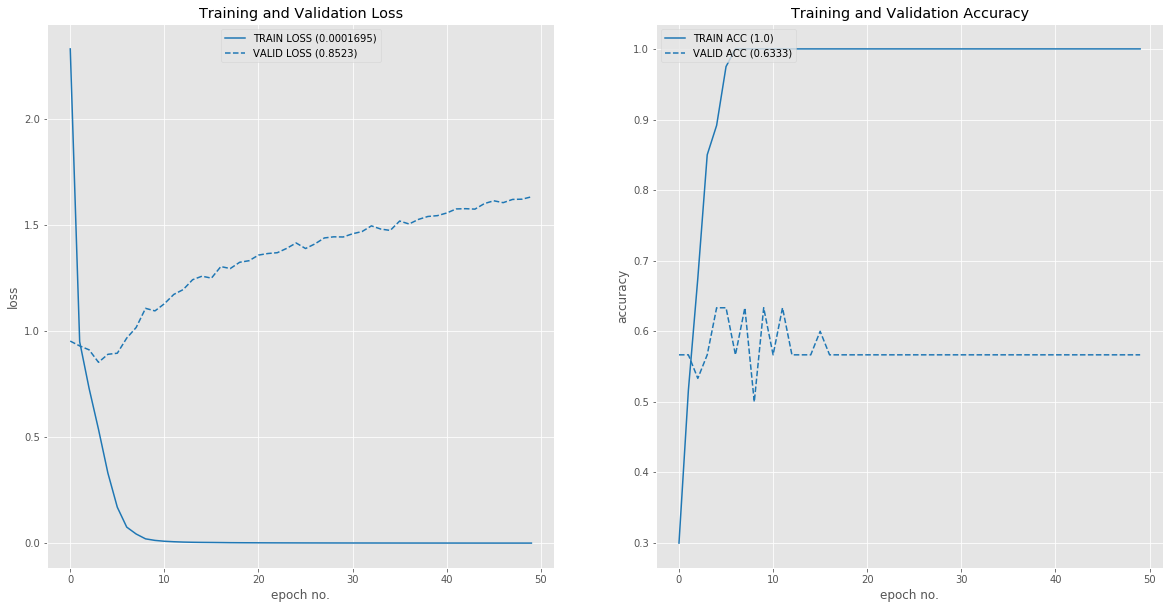

In [31]:
plot_loss_accuracy(train_loss=[train_loss], 
                   val_loss=[val_loss], 
                   train_acc=[train_acc], 
                   val_acc=[val_acc], 
                   colors=['blue'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

# <font style="color:blue">5. Sample Prediction</font>

Show some sample predictions.

## <font style="color:blue">5.1. Make Predictions</font>

In [32]:
def prediction(model, device, batch_input):
    
    # send model to cpu/cuda according to your system configuration
    model.to(device)
    
    # it is important to do model.eval() before prediction
    model.eval()

    data = batch_input.to(device)

    output = model(data)

    # Score to probability using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

## <font style="color:blue">5.2. Get predictions on a batch</font>

In [33]:
def get_sample_prediction(model, data_root, mean, std):
    batch_size = 15

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2
        
        
    
    # transformed data
    test_dataset_trans = datasets.ImageFolder(root=data_root, transform=image_common_transforms(mean, std))
    
    # original image dataset
    test_dataset = datasets.ImageFolder(root=data_root, transform=image_preprocess_transforms())
    
    data_len = test_dataset.__len__()
    
    interval = int(data_len/batch_size)
    
    imgs = []
    inputs = []
    targets = []
    for i in range(batch_size):
        index = i * interval
        trans_input, target = test_dataset_trans.__getitem__(index)
        img, _ = test_dataset.__getitem__(index)
        
        imgs.append(img)
        inputs.append(trans_input)
        targets.append(target)
        
    inputs = torch.stack(inputs)
        
    cls, prob = prediction(model, device, batch_input=inputs)
    
    plt.style.use('default')
    plt.rcParams["figure.figsize"] = (15, 9)
    fig = plt.figure()
    
    
    for i, target in enumerate(targets):
        plt.subplot(3, 5, i+1)
        img = transforms.functional.to_pil_image(imgs[i])
        plt.imshow(img)
        plt.gca().set_title('P:{0}({1:.2}), T:{2}'.format(test_dataset.classes[cls[i]], 
                                                     prob[i], 
                                                     test_dataset.classes[targets[i]]))
    fig.savefig('sample_prediction.png')
    plt.show()
    
    return
        
    

## <font style="color:blue">5.3. Load Model and Run Inference</font>

mean: tensor([0.4610, 0.4347, 0.3897]), std: tensor([0.2400, 0.2356, 0.2306])


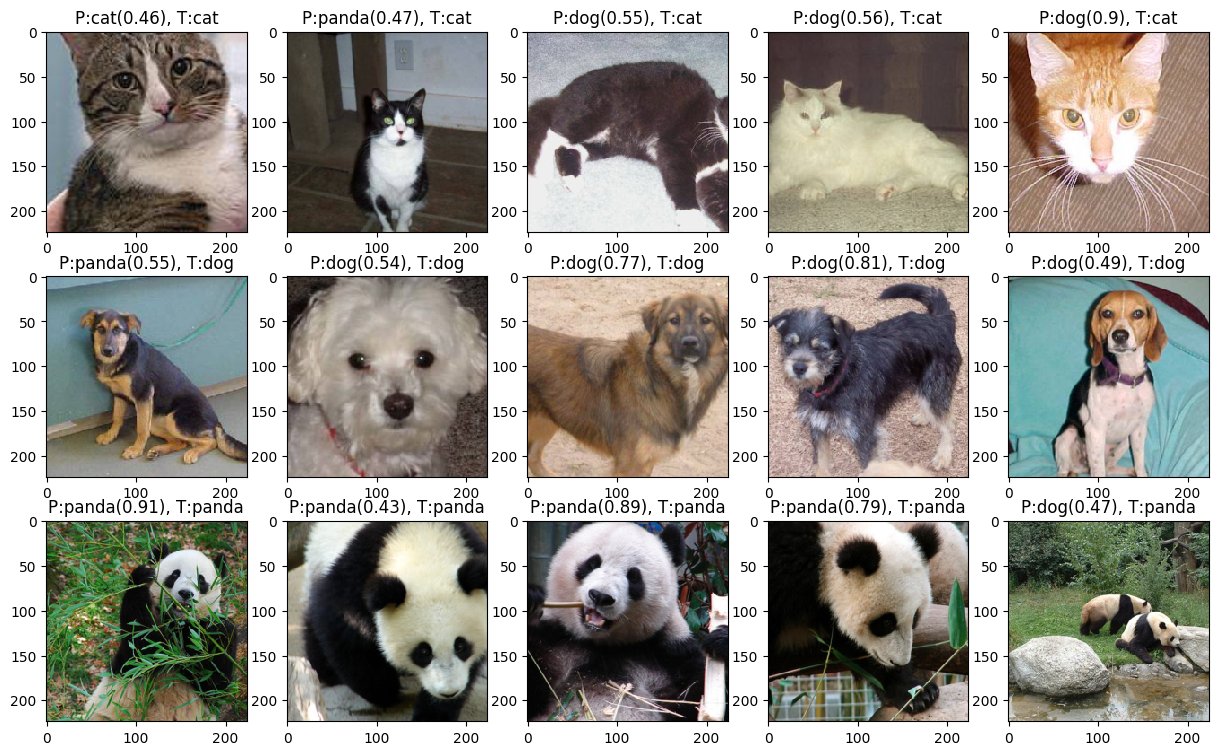

In [34]:
m = MyModel()

m = load_model(m)

train_config = TrainingConfiguration()

test_data_path = os.path.join(train_config.data_root, 'validation')

train_data_path = os.path.join(train_config.data_root, 'training')

mean, std = get_mean_std(train_data_path)


get_sample_prediction(m, test_data_path, mean, std)

You can see that even though the network is trained on a very small subset if data, the predictions are not that bad. This means that our model is ready to be trained.

# <font style="color:red">6. Display Mistakes [15 points] </font>
In the above code, sample predictions were displayed. But correct predictions are hardly of any use. You should write a similar function which displays only the mistakes made by the network.

**You have to display only 15 images.**

After you have completed the assignment, <font style="color:red">upload and submit the notebook on the portal</font> so that we can check and provide feedback.